# Conlusions
### Clustering
The KMeans clustering with three clusters appears to more or less have taken one of the clusters obtained with `n_components=2`, and split it in two. This caused difficulties in separating the two new clusters, and did not provide useful insights. We therefore focused on two clusters for obtaining customer profiles. 
### Separating features
The features that separate the clusters are `Kidhome`, `MntWines`, `NumStorePurchases`, `MntFishMeatProdcts`.
### Customer profiles
|Customer group 0|Customer group 1|
|----------------|----------------|
|Has kids        |No kids         |
|Fewer purchases*|More purchases, both online and in store**|
|Spend more across all categories***|Spend less|

*Despite having fewer web purchases, group 0 visit the web more often.
**In addition to shopping more often, group 1 has higher average spend.
***Most prominent differences in wine and meat/fish.

### Additional insights
Those who accept more campaigns (>3)
- are more educated
- has fewer kids
- spend a lot on wine, but not much in the other categories
- make more purchases in the store than the web


### PCA 
Visualization with PCA `p=2` and `p=3` strongly suggested three non-spherical clusters. Thus, as expected, the clustering from KMeans did not align with the clustering proposed by PCA.

### t-SNE
Visualization with t-SNE suggested four to six clusters. The clustering from KMeans did not align with the clustering proposed by t-SNE.

### DBSCAN
DBSACN handles non-spherical clusters better than KMeans. Out of curiosity, to see whether the clusters suggested by PCA provides any insights, we tried to 
1. apply PCA to the data
2. use DBSCAN on the result from PCA.

The clustering suggested by PCA aligned witht the result from DBSCAN. The clustering was however based exclusively on the feature `Years_customer`, and provide no insights. We therefore tried to remove this feature before applying PCA and DBSCAN. This resulted in just one cloud of data points, so we ceased to pursue this approach.

### Years_customer
The insights from DBSACN led us to try to remove the feature `Years_customer`, and then see if KMeans provided better clustering. For `k=2` this provided more separated clusters. However, due to shortage of time, we did not pursue this further. 

# Clustering using k-means

This notebook shows the clustering part of the assignment. For simplicity, it uses the custom `Preprocessor` class for data preparation. 

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from preprocessor import Preprocessor
import seaborn as sns
import pandas as pd
import numpy as np

prep = Preprocessor()

We start by looking at whether the clustering is better with or without the new features, and simultaneously finding a suggestion for the optimal number of k.

In [2]:
# Code retrieved and modified from example notebook

def get_metrics(df):
       sse = []
       silhouettes = []
       for i in range(2, 11):
              km = KMeans(n_clusters=i,random_state=0)
              labels = km.fit_predict(df)
              sse.append(km.inertia_)
              silhouettes.append(silhouette_score(df, labels))
       return sse, silhouettes

Removing 9 wine outliers
Removing 34 fruit outliers
Removing 2 sweets outliers
Removing 3 gold outliers
Removing 0 web purchase outliers
Removing 5 fish_meat outliers
Removing 9 wine outliers
Removing 34 fruit outliers
Removing 2 sweets outliers
Removing 3 gold outliers
Removing 0 web purchase outliers
Removing 5 fish_meat outliers


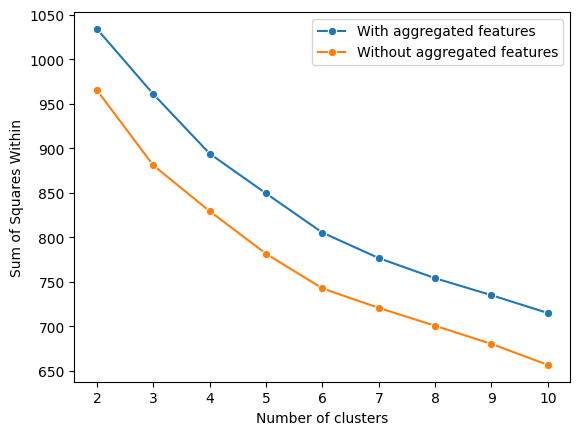

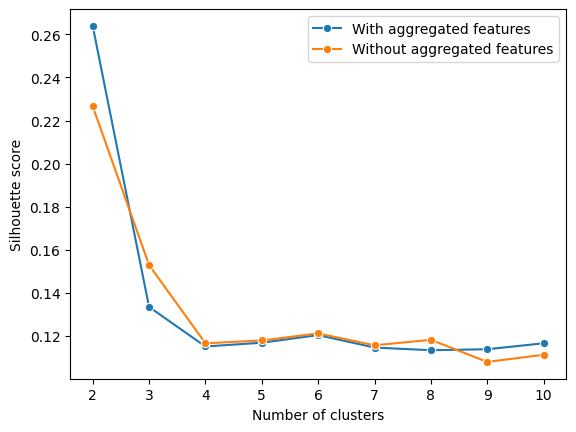

In [3]:
df_with, _ = prep.get_data(test_size=-1, remove_outliers=True, aggregate_features=True)
sse_with, silhouette_with = get_metrics(df_with)

df_without, _ = prep.get_data(test_size=-1, remove_outliers=True, aggregate_features=False)
sse_without, silhouette_without = get_metrics(df_without)

sns.lineplot(x=range(2,11),y=sse_with,marker='o', label='With aggregated features');
sns.lineplot(x=range(2,11),y=sse_without,marker='o', label='Without aggregated features');
plt.xlabel('Number of clusters') 
plt.ylabel('Sum of Squares Within');

xpoints = [10,2]
ypoints = [sse_with[-1],sse_with[0]]
# sns.lineplot(x=xpoints,y=ypoints);
plt.show()

# Plot silhouette score
sns.lineplot(x=range(2,11),y=silhouette_with,marker='o', label='With aggregated features');
sns.lineplot(x=range(2,11),y=silhouette_without,marker='o', label='Without aggregated features');
plt.xlabel('Number of clusters') 
plt.ylabel('Silhouette score');

xpoints = [10,2]
ypoints_with = [silhouette_with[-1],silhouette_with[0]]
# sns.lineplot(x=xpoints,y=ypoints_with);
plt.show()

The kmeans clustering has consistently lower SSE without aggregated features than with, suggesting stronger cohesion without the aggregated features. The silhouette score is lower for k=2, higher for k=3, and effectively similar for k>=4. We will therefore not aggregate new features prior to the clustering, but rather generate them afterwards to find patterns in the dataset. 

### Optimal K

- The elbow method plotting SSE (wihtout aggregated features) suggests k=3 or k=6 as the optimal number of neighbors. 
- The silhoutte score plotting (without aggregated features) shows a significant decrease from 2 to 3, and further from 3 to 4. 

The poor clustering for k>3, combined with the observations for the SSE, tells us to look into k=2 and k=3 for the optimal number of clusters.

We proceed by looking at how the clusters differ from each other, by plotting a parallel coordinate plot and calculating the standard deviation of each cluster.

In [4]:
# Methods to be used for both k=2 and k=3

from pandas.plotting import parallel_coordinates

# Parallel coordinates plot
def plot_parallel(km, df, k):
    
    data = df.copy()
    
    # Extract the cluster centers
    centers = km.cluster_centers_

    # Create a DataFrame from the cluster centers
    centers_df = pd.DataFrame(centers, columns=data.columns)
    centers_df['Cluster'] = [f'Cluster {i}' for i in range(k)]

    # Plot the parallel coordinates
    plt.figure(figsize=(12, 6))
    parallel_coordinates(centers_df, 'Cluster', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Parallel Coordinates Plot of Cluster Centers')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Cluster')
    plt.show()


# Standard deviations bar chart
def plot_std(km, df, k):
    data = df.copy()
    
    # Extract the cluster centers
    centers = km.cluster_centers_

    # Create a DataFrame from the cluster centers
    centers_df = pd.DataFrame(centers, columns=data.columns)

    # Compute the standard deviation for each variable across the cluster centers
    std_dev = centers_df.std()
    # Create a bar plot for the standard deviations
    plt.figure(figsize=(10, 6))
    std_dev.plot(kind='bar', color='skyblue')
    plt.title('Standard Deviation of Cluster Center Values Across Variables')
    plt.xlabel('Variables')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', which='both', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Comparisons scatter plot
def plot_comparisons(df):
    color_map = {0: 'red', 1: 'blue', 2: 'green'}

    # Aggregate new features
    data = df.copy()
    data = Preprocessor.aggregate_features(data)

    feature_pairs = [
        ('Kidhome','MntWines'),
        ('Kidhome','MntGoldProds'),
        ('Kidhome','MntFishMeatProdcts'),
        ('Kidhome','MntFruits'),
        ('Kidhome','MntSweetProducts'),
        ('Kidhome','NumWebPurchases'),
        ('Kidhome','NumStorePurchases'),
        ('Kidhome','NumWebVisitsMonth'),
        ('Kidhome','Recency'),
        ('MntWines','MntFishMeatProdcts'),
        ('MntWines','MntFruits'),
        ('MntWines','MntSweetProducts'),
        ('MntWines','MntGoldProds'),
        ('NumWebPurchases','NumStorePurchases'),
        ('NumWebPurchases','NumWebVisitsMonth'),
        ('Num_AcceptedCmp', 'NumStorePurchases'),
        ('Num_AcceptedCmp', 'NumWebPurchases'),
        ('Num_AcceptedCmp','MntFishMeatProdcts'),
        ('Num_AcceptedCmp','MntFruits'),
        ('Num_AcceptedCmp','MntSweetProducts'),
        ('Num_AcceptedCmp','MntGoldProds'),
        ('Num_AcceptedCmp','MntWines'),
        ('Num_AcceptedCmp','Years_customer'),
        ('Num_AcceptedCmp','Age'),
        ('Num_AcceptedCmp','Education'),
        ('Num_AcceptedCmp','Kidhome'),
        ('TotalSpend', 'AvgSpendPerPurchase'),
        ('TotalSpend', 'TotalPurchases'),
        ('Num_AcceptedCmp', 'TotalSpend'),
    ]


    # Determine layout size
    n_plots = len(feature_pairs)
    n_cols = 2 
    n_rows = (n_plots + 1) // n_cols 

    # Create scatter plots for each combination of features
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

    # Flatten the axis array for easier indexing
    axs = axs.flatten()

    for i, combination in enumerate(feature_pairs):
        feat1 = combination[0]
        feat2 = combination[1]
        axs[i].scatter(data[feat1], data[feat2], c=data['Cluster'].map(color_map), alpha=0.5)
        axs[i].set_xlabel(feat1)
        axs[i].set_ylabel(feat2)
        axs[i].set_title(f'{feat1} vs {feat2}')

    # Turn off any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_histograms(df):
    color_map = {0: 'red', 1: 'blue', 2: 'green'}

    # Aggregate new features
    data = df.copy()
    data = Preprocessor.aggregate_features(data)

    # Iterating over features
    for feature in data.columns:
        plt.figure(figsize=(10, 6))

        # Iterating over clusters per feature
        for cluster in sorted(data['Cluster'].unique()):
            subset = data[data['Cluster'] == cluster]
            plt.hist(subset[feature], bins=30, alpha=0.5, label=f'Cluster {cluster}', color=color_map[cluster])

        plt.title(f'Distribution of {feature} Across Clusters')
        plt.xlabel(f'{feature}')
        plt.ylabel('Frequency')
        plt.legend(title='Cluster')
        plt.grid(True)
    plt.show()

    

## Two clusters

### Differences between the two clusters

From the parallel coordinates plot and the standard deviations we see that in general the features can be categorized in features that are similar between the clusters (not defining), features that differs greatly (defining), and features that can be deemed neutral:

**Defining**
- `Kidhome`
- `MntWines`
- `NumStorePurchases`
- `MntFishMeatProdcts`

**Neutral**
- `MntFruits`
- `MntSweetProducts`
- `MntGoldProducts`
- `NumWebPurchases`
- `Age`

**Not defining**
- `Education`
- `Recency`
- `NumWebVisitsMonth`
- `Years_customer`
- `Num_AcceptedCmp`

In [5]:
data_2, _ = prep.get_data(test_size=-1, remove_outliers=True, aggregate_features=False)
print(data_2.columns)

Removing 9 wine outliers
Removing 34 fruit outliers
Removing 2 sweets outliers
Removing 3 gold outliers
Removing 0 web purchase outliers
Removing 5 fish_meat outliers
Index(['Education', 'Kidhome', 'Recency', 'MntWines', 'MntFruits',
       'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Years_customer',
       'Num_AcceptedCmp', 'MntFishMeatProdcts'],
      dtype='object')


In [6]:
km_2 = KMeans(2)
km_2.fit(data_2)

KMeans(n_clusters=2)

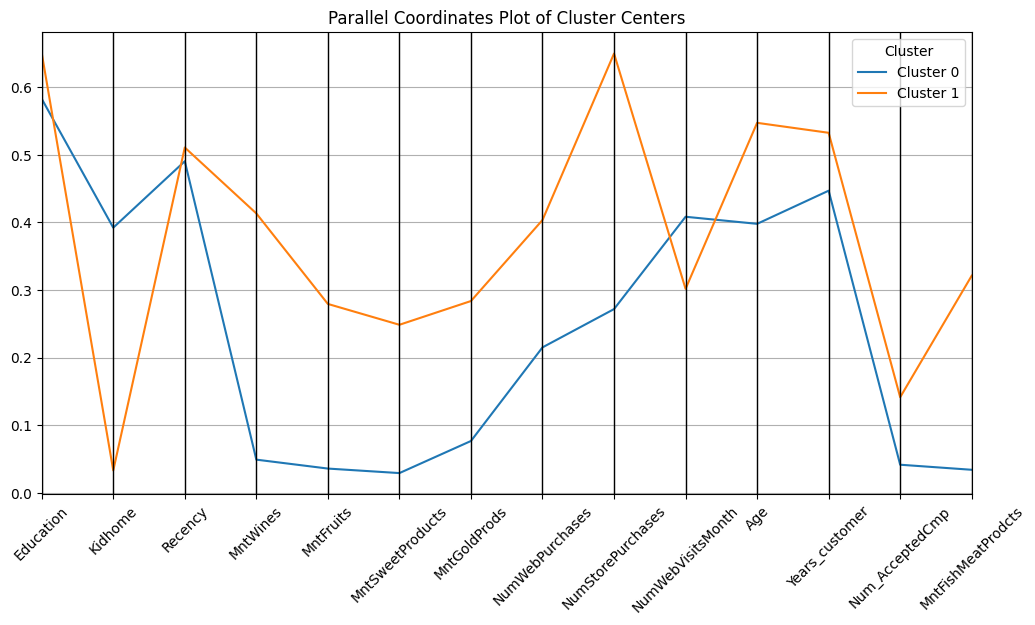

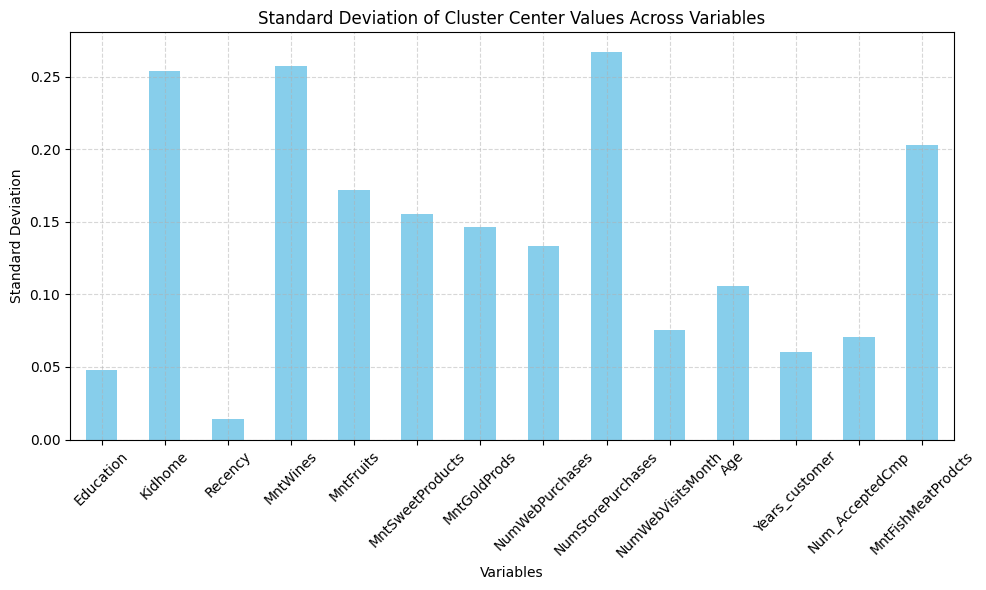

In [7]:
plot_parallel(km_2, data_2, 2)
plot_std(km_2, data_2, 2)

### Defining the clusters

Next we apply two methods to extract general patterns and differences between clusters:
1. Scatter plots for a number of interesting combinations of features. 
2. Histograms for each feature inside each cluster.

#### Findings
*The two clusters are hereby referred to as R (red) and B (blue).*

- B tends to spend more than R in all the spend categories. 
- B has mostly no kids, while R usually has 1 kid. 
- Both B and R have the entire range of age. However, 
    - R has highest concentration around the age 35-55.
    - B are generally older than R.
- B prefers store purchases, whereas R prefers web.
- R has fewer purchases (both web and store) than B. However, R has more web visits than B. 
- Customers with kids spend considerably less
- Customers who accept four or five campaigns
    - has higher education
    - has fewer kids
    - spend a lot on wine
    - spend less on gold, sweets and fruits
- R spends considerably less than R.
- R has considerably less purchases than B.
- B accepts more campaigns than R
- Total spend is more affected by the average spend per purchase than by how many purchases the customer makes. 


In [8]:
# unscale the data
scaler = prep.get_scaler()
unscaled = scaler.inverse_transform(data_2)
unscaled_data_2 = pd.DataFrame(unscaled, index=data_2.index, columns=data_2.columns)

# Extract cluster labels
unscaled_data_2['Cluster'] = km_2.labels_

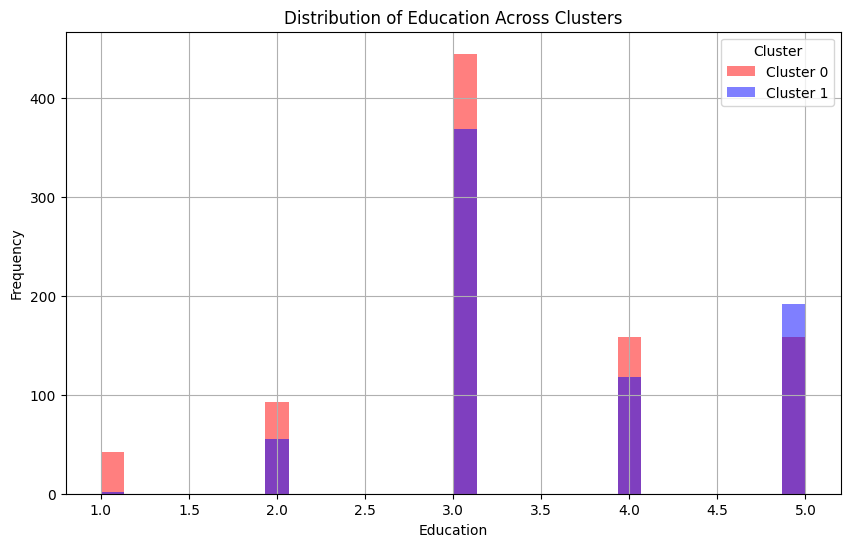

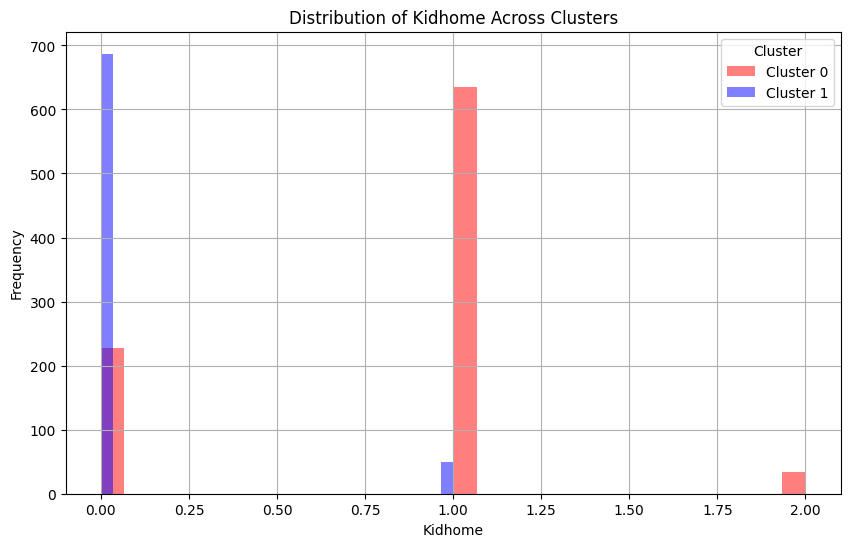

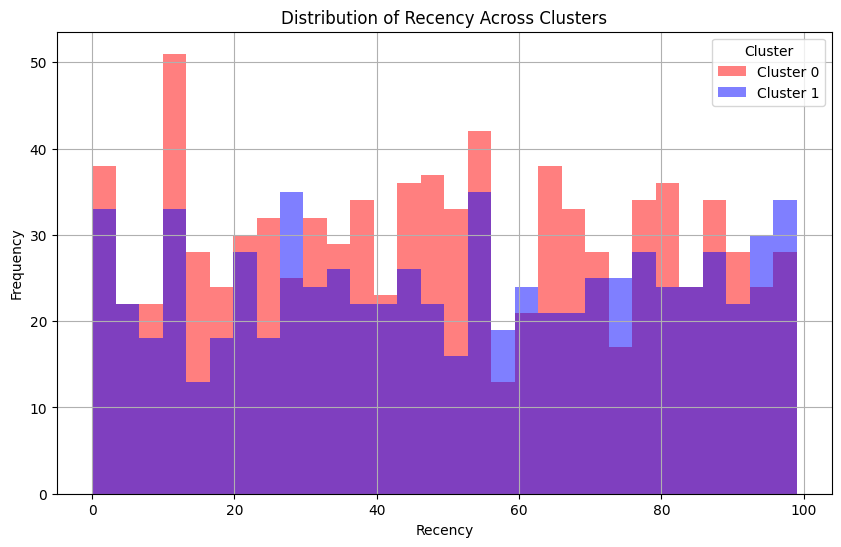

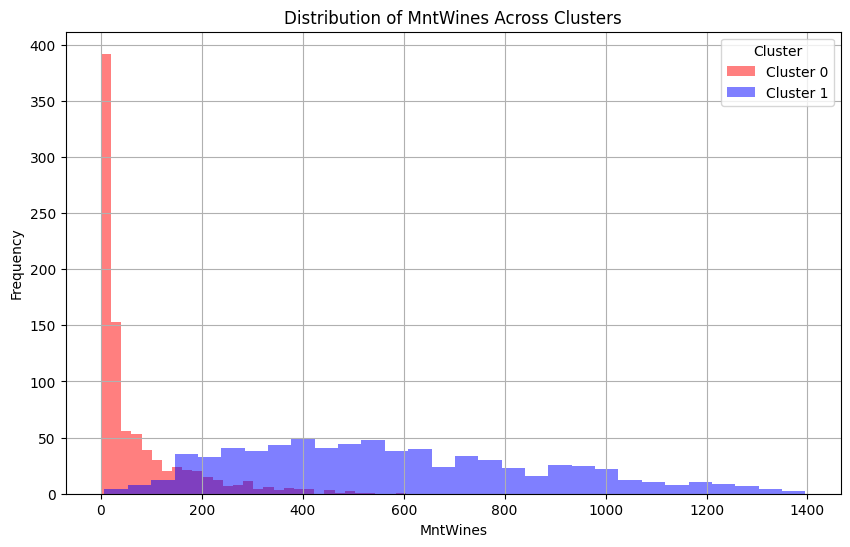

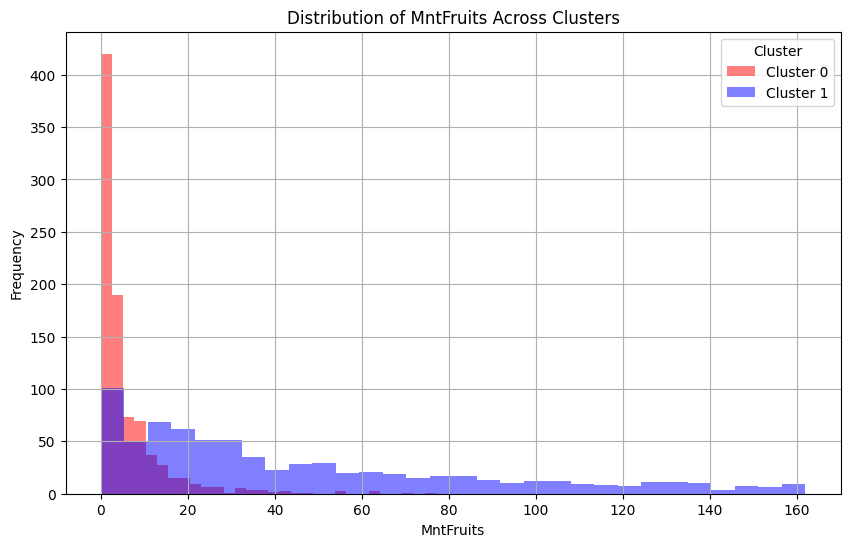

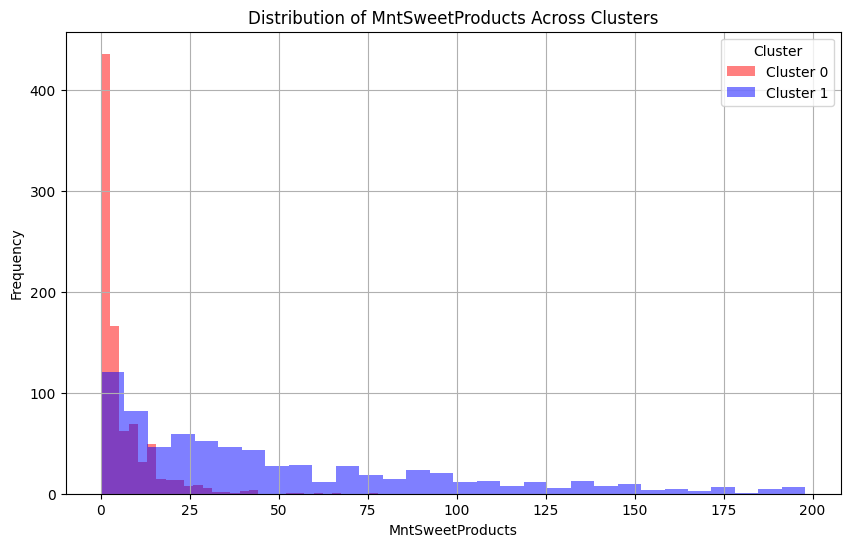

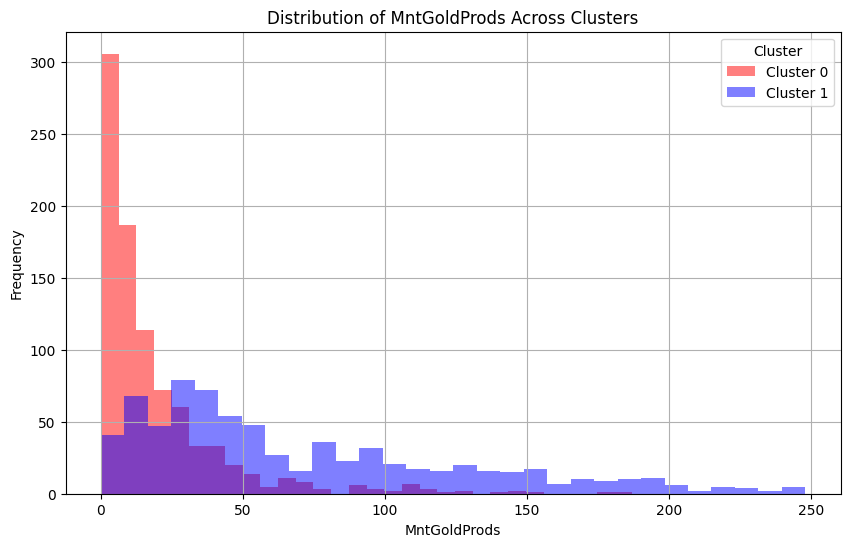

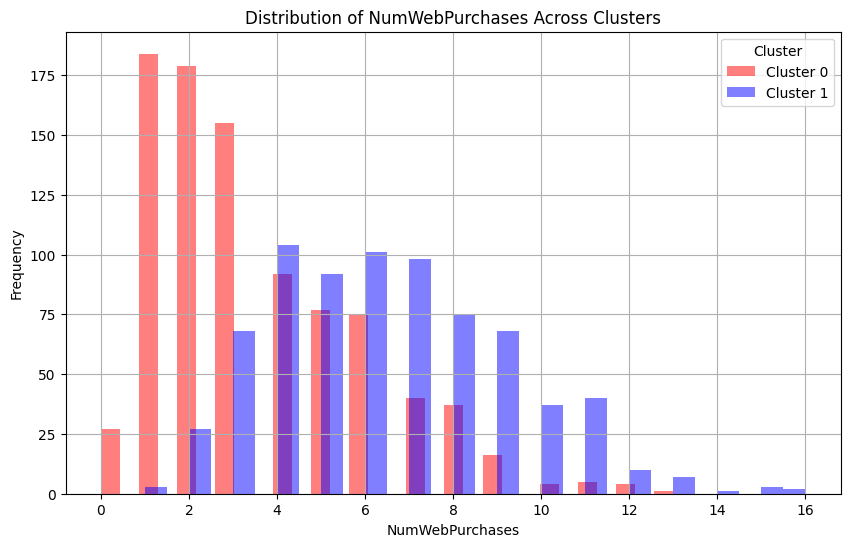

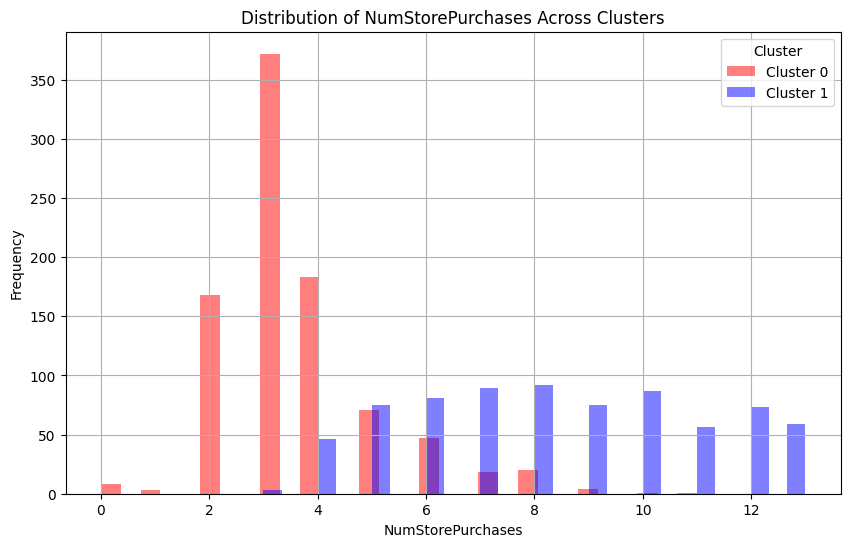

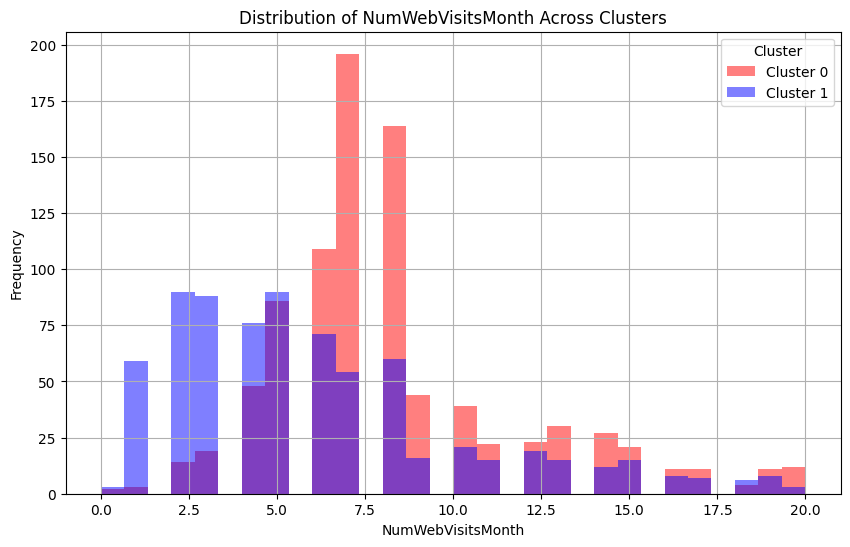

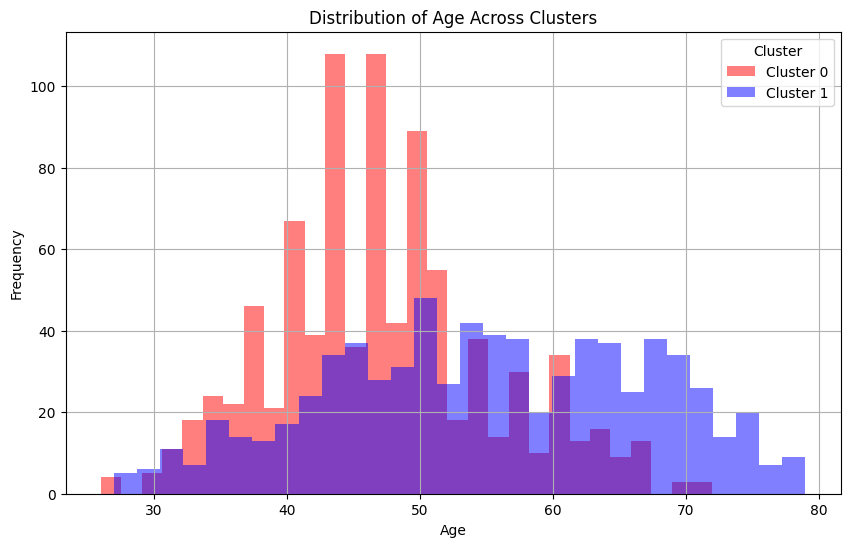

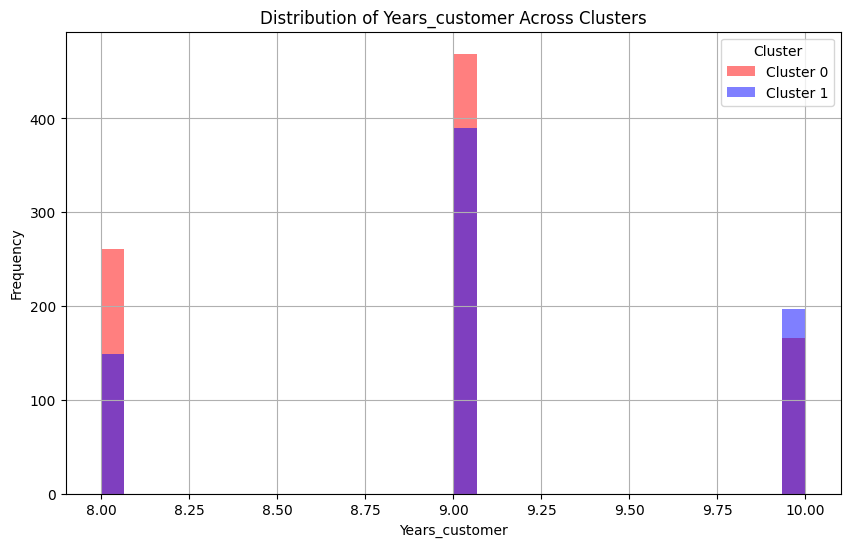

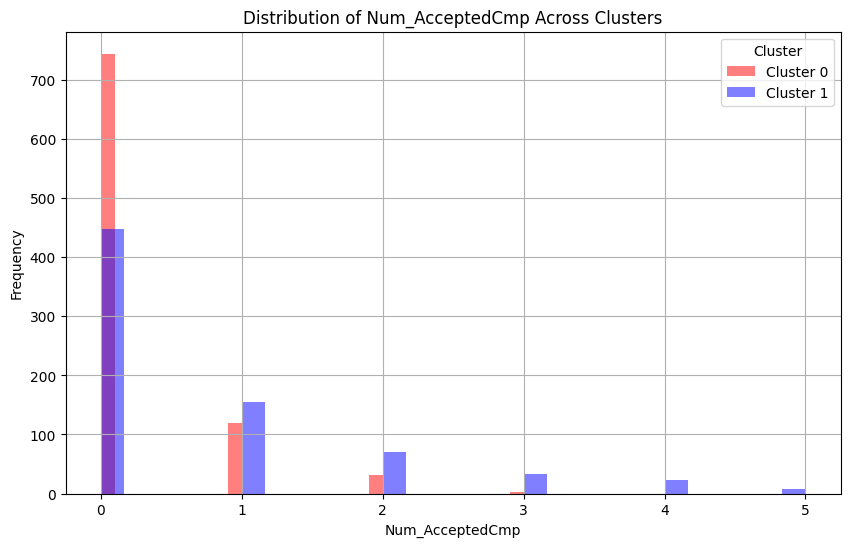

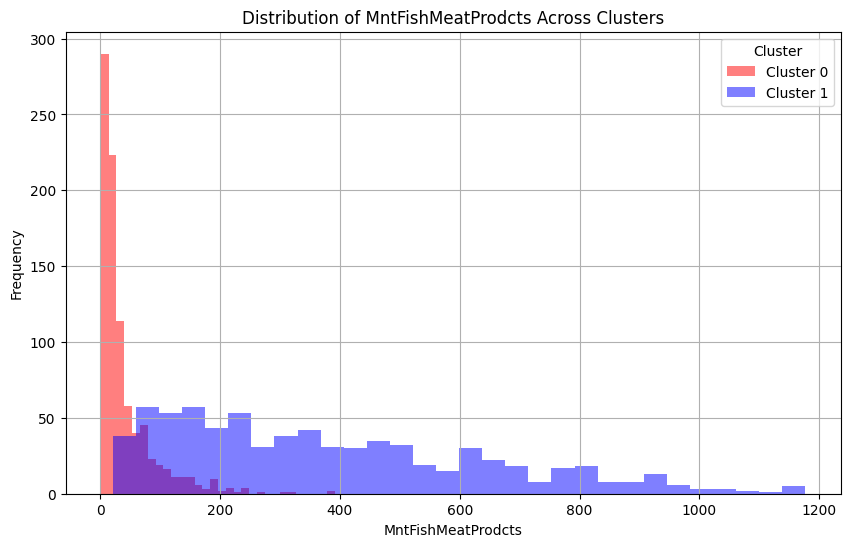

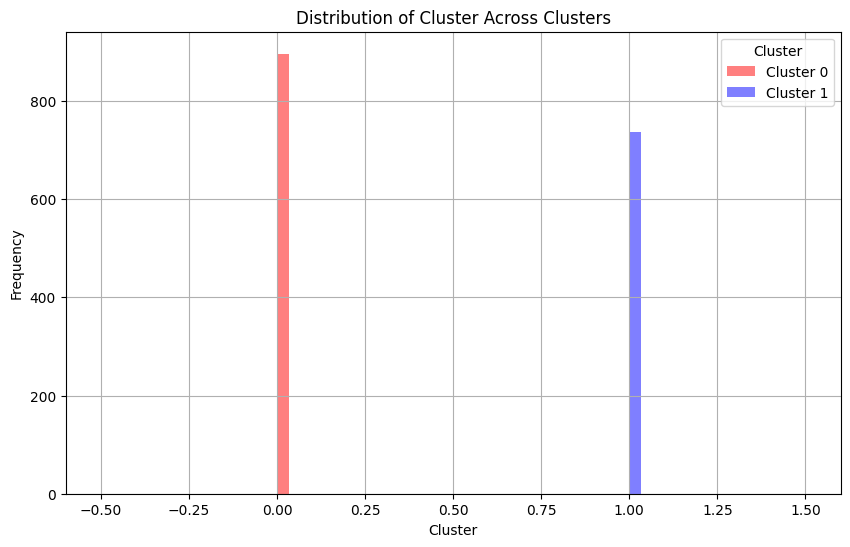

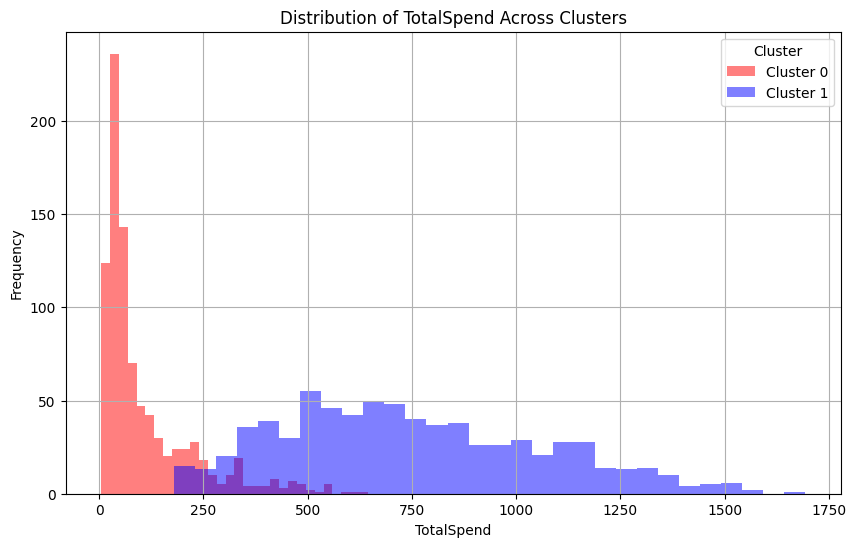

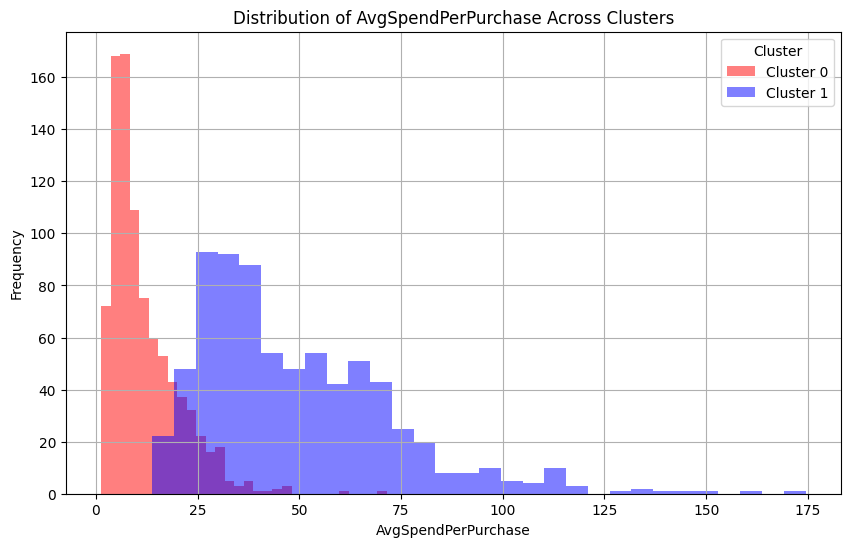

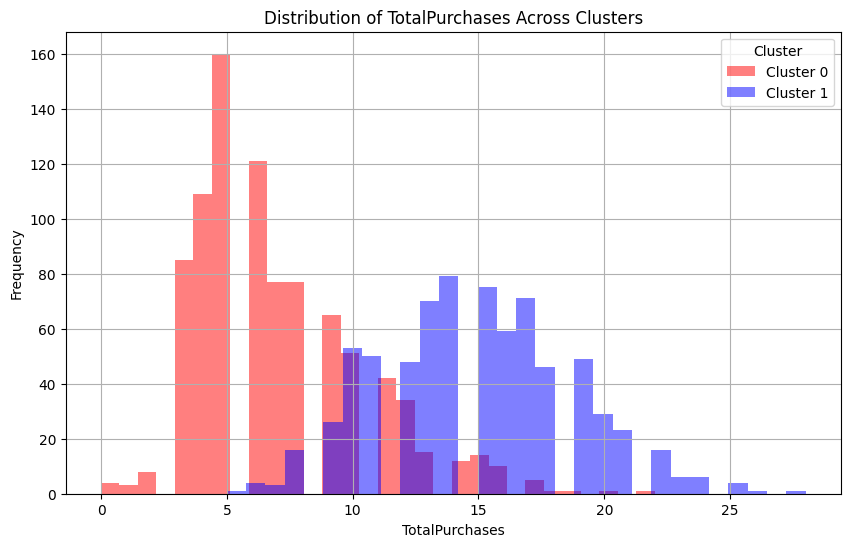

In [9]:
plot_histograms(unscaled_data_2)


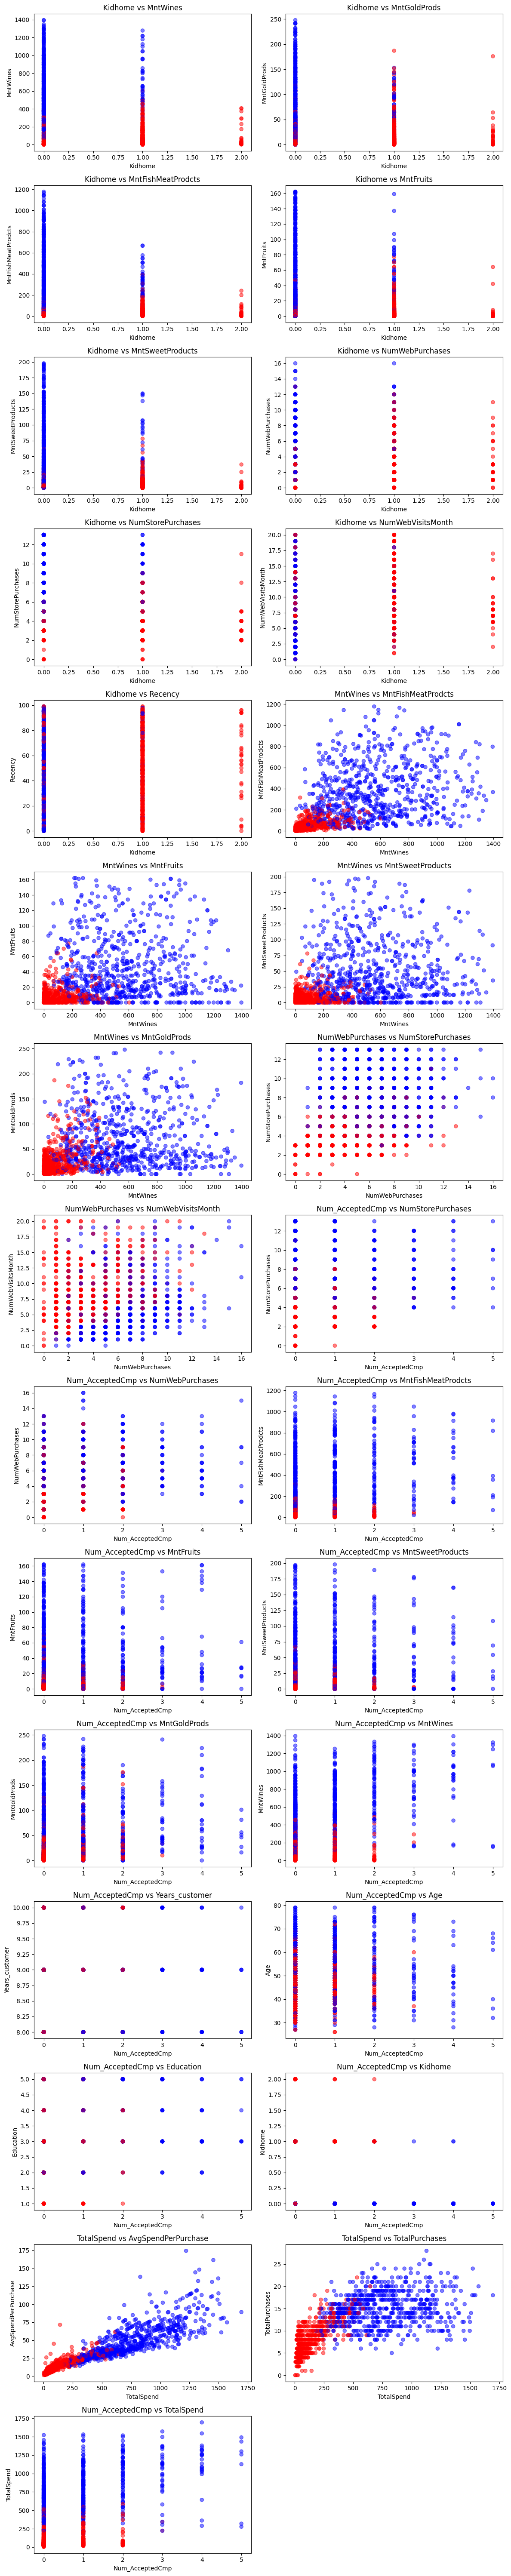

In [10]:
# Plotting histograms
plot_comparisons(unscaled_data_2)

## Three clusters

### Differences between the two clusters

In the parallel coordinates plot we see that the centers of R and G follow each other closely. If the clusters are dense (i.e. low variations within the clusters), it will be difficult to obtain good characteristics of the separate clusters.
 
From the parallel coordinates plot and the standard deviations we see that in general the features can be categorized in features that are similar between the clusters (not defining), features that differs greatly (defining), and features that can be deemed neutral:

**Defining**
- `KidHome`
- `Years_customer`
- `MntWines`
- `NumStorePurchases`
- `MntFishMeatProdcts`

**Neutral**
- `MntFruits`
- `MntSweetProducts`
- `MntGoldProducts`
- `NumWebPurchases`

**Not defining**
- `Education`
- `Recency`
- `NumWebVisitsMonth`
- `Age`
- `Num_AcceptedCmp`

In [11]:
data_3, _ = prep.get_data(test_size=-1, remove_outliers=True, aggregate_features=False)

Removing 9 wine outliers
Removing 34 fruit outliers
Removing 2 sweets outliers
Removing 3 gold outliers
Removing 0 web purchase outliers
Removing 5 fish_meat outliers


In [12]:
km_3 = KMeans(n_clusters=3, random_state=0)
km_3.fit(data_3)

KMeans(n_clusters=3, random_state=0)

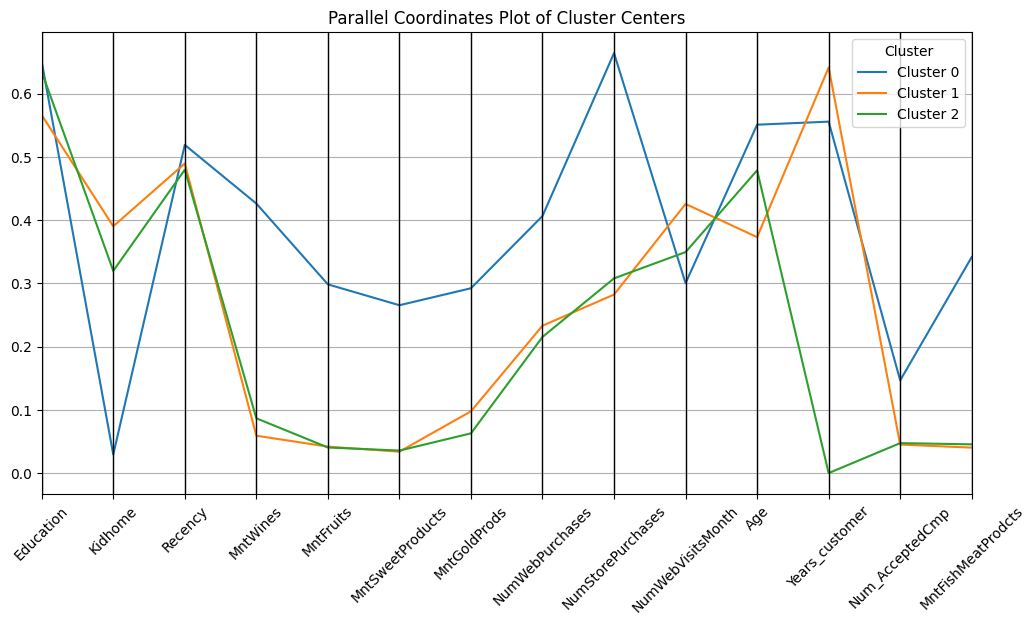

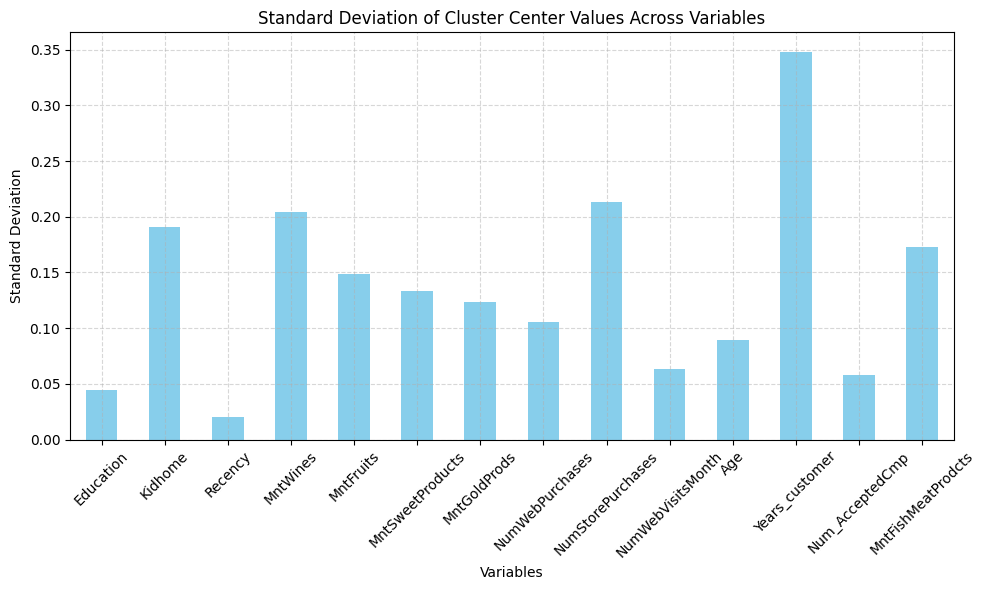

In [13]:
plot_parallel(km_3, data_3, 3)
plot_std(km_3, data_3, 3)

### Defining the clusters

Next we apply two methods to extract general patterns and differences between clusters:
1. Scatter plots for a number of interesting combinations of features. 
2. Histograms for each feature inside each cluster.

#### Findings

As implied by the parallel coordinates plot of the cluster centers, clusters 1 and 2 do not differ significantly enough to obtain any clear differences. They seem to follow roughly the same distribution, but cluster 2 has significantly less instances than cluster 1.

In [14]:
# unscale the data
scaler = prep.get_scaler()
unscaled = scaler.inverse_transform(data_3)
unscaled_data_3 = pd.DataFrame(unscaled, index=data_3.index, columns=data_3.columns)

# Extract cluster labels
unscaled_data_3['Cluster'] = km_3.labels_

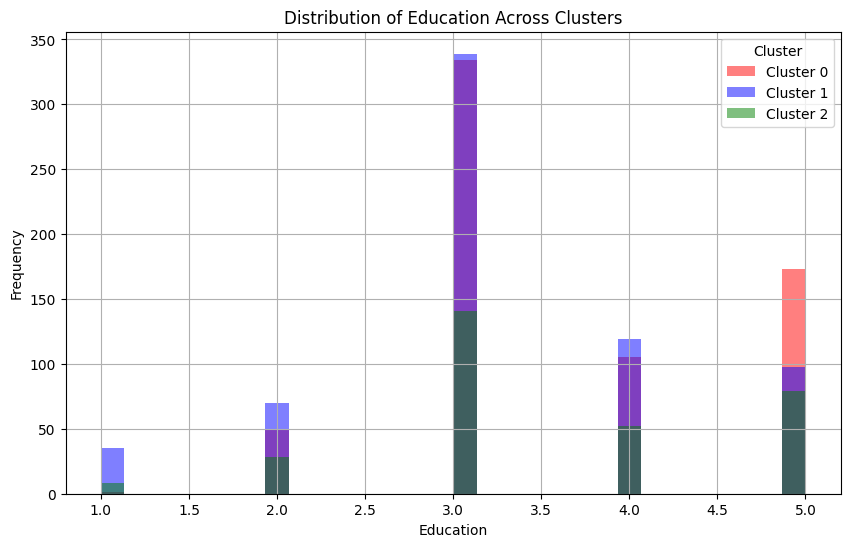

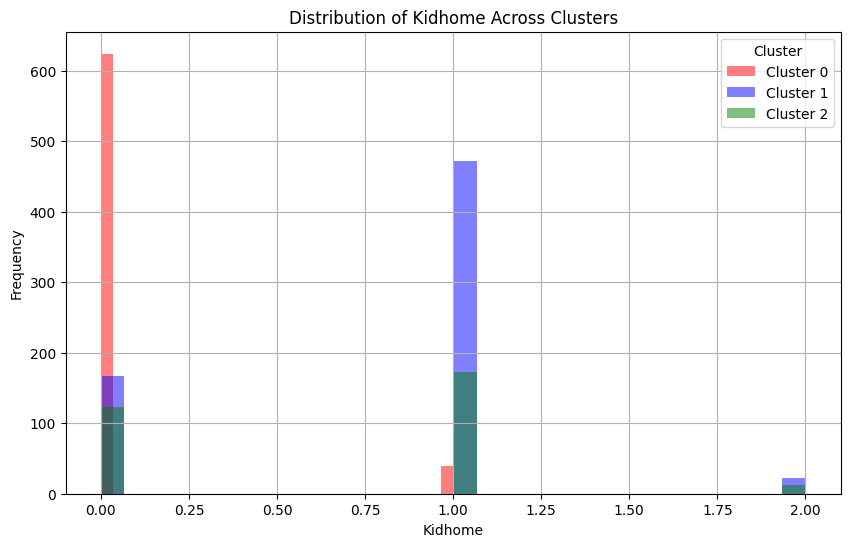

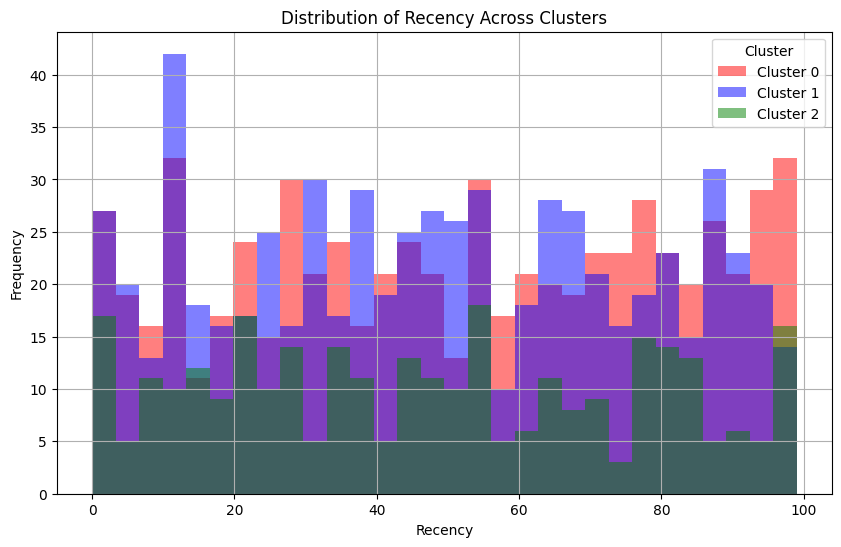

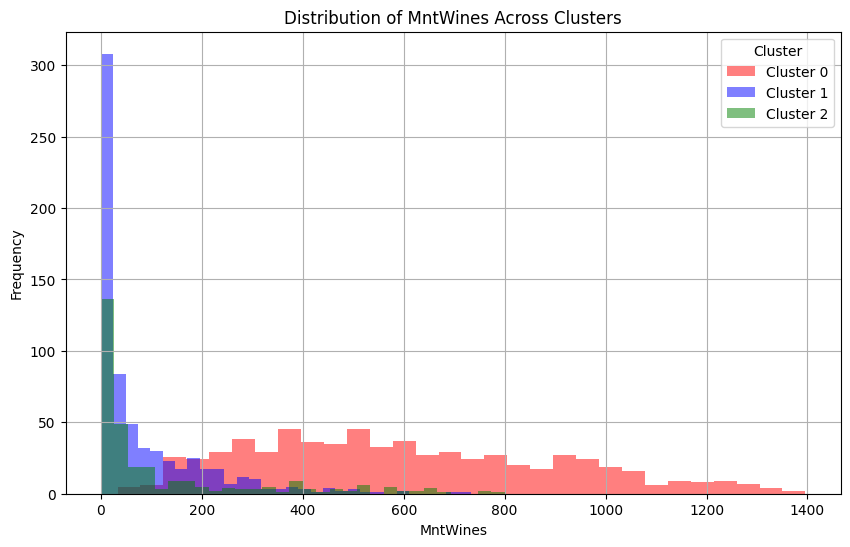

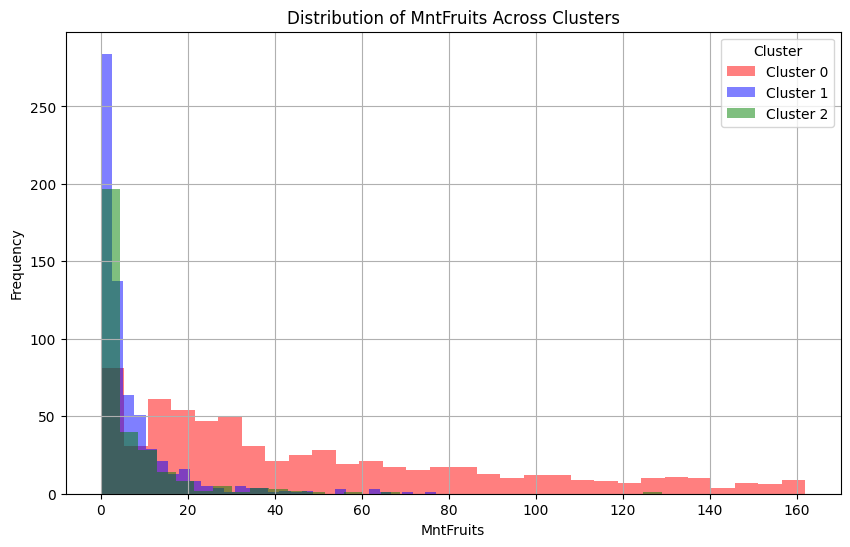

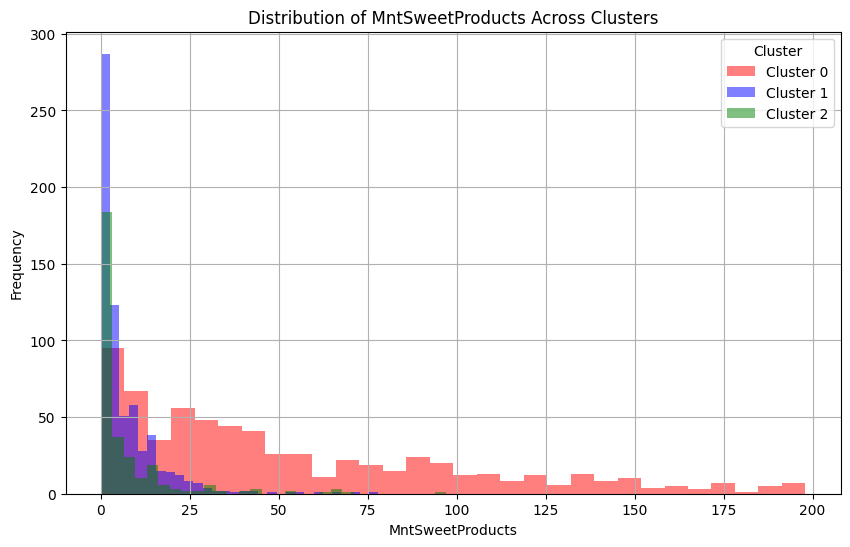

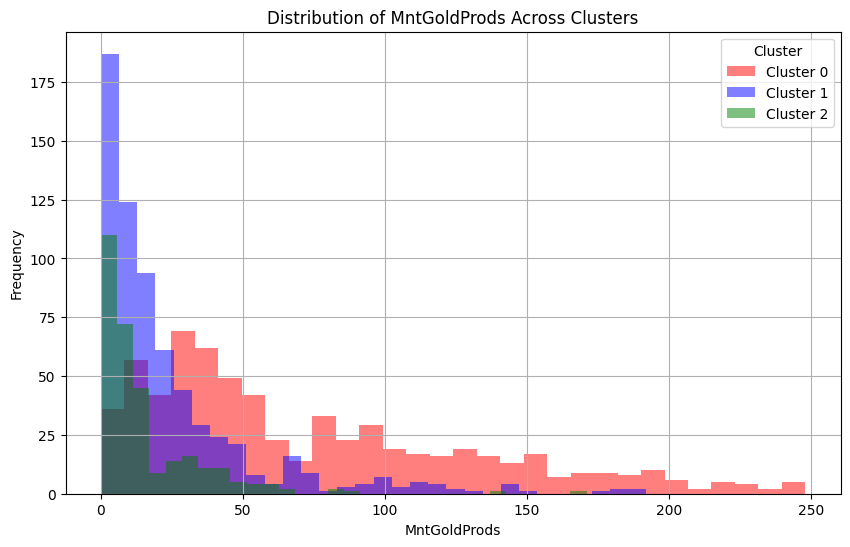

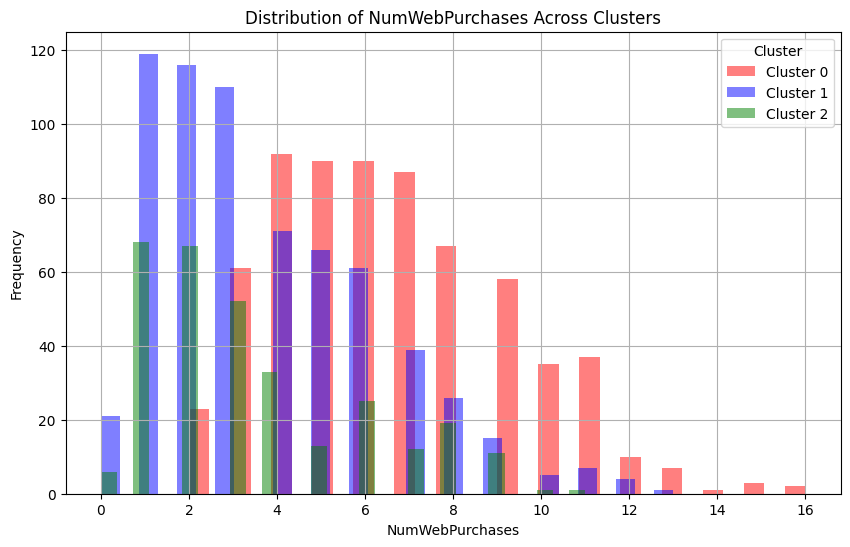

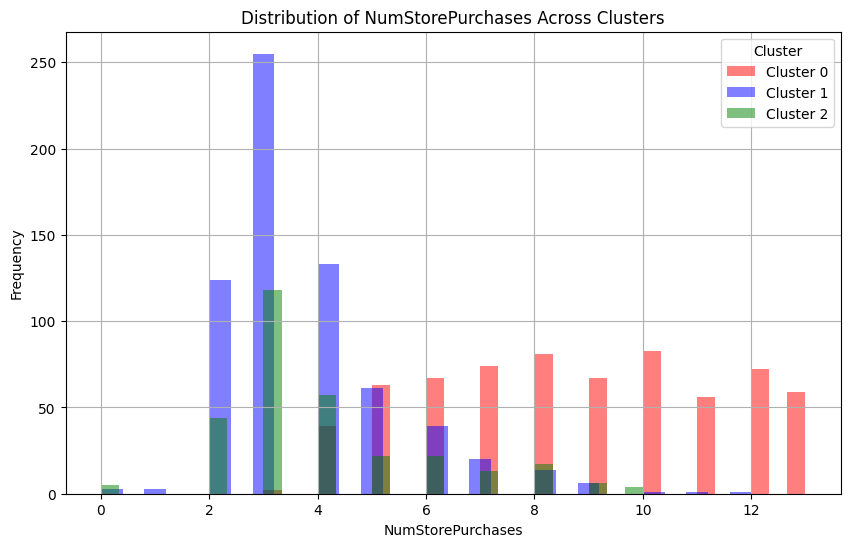

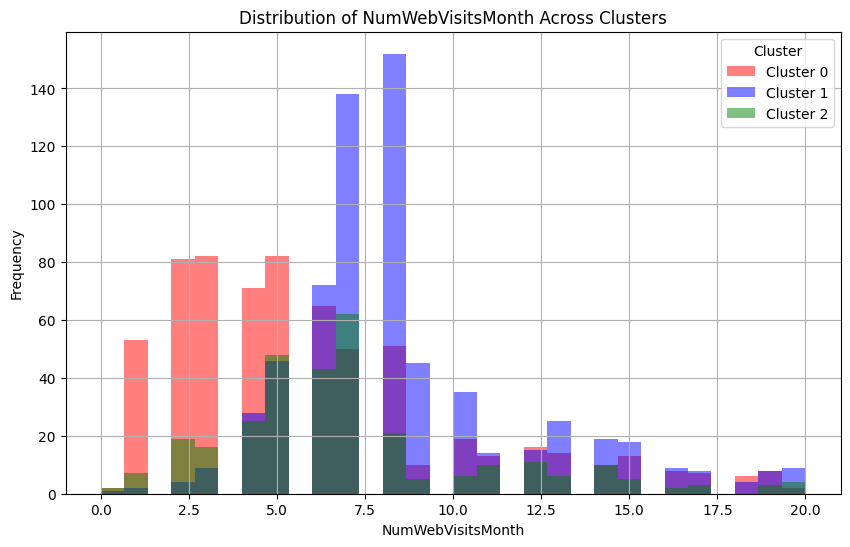

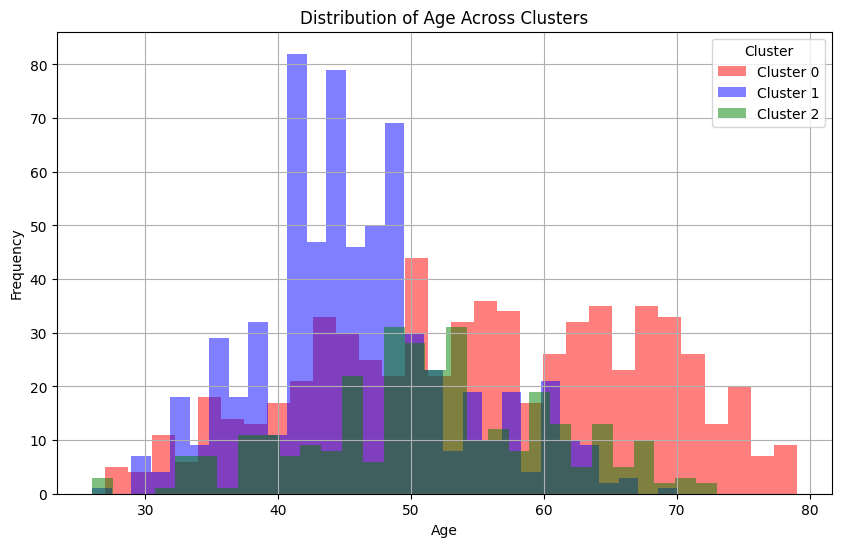

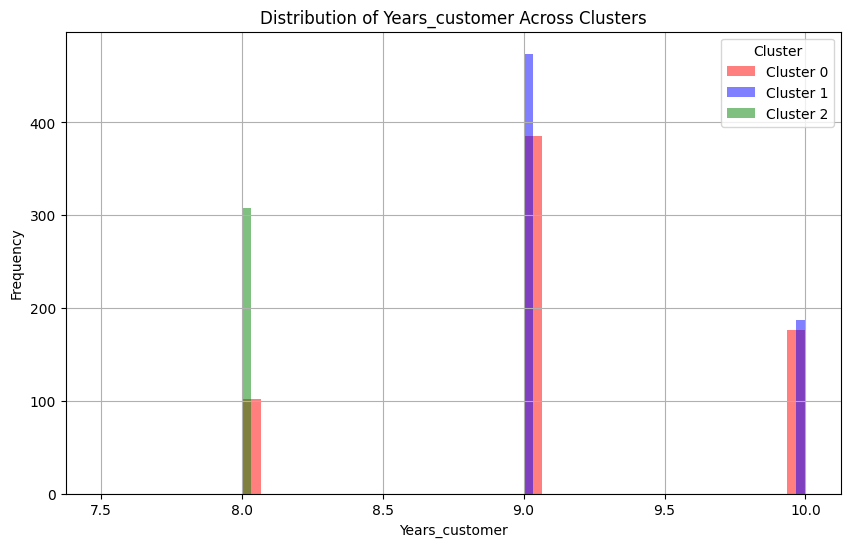

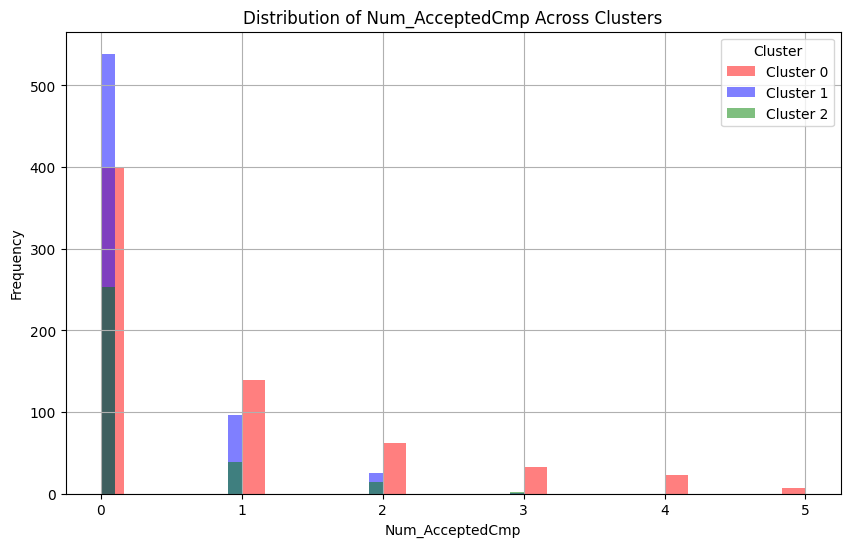

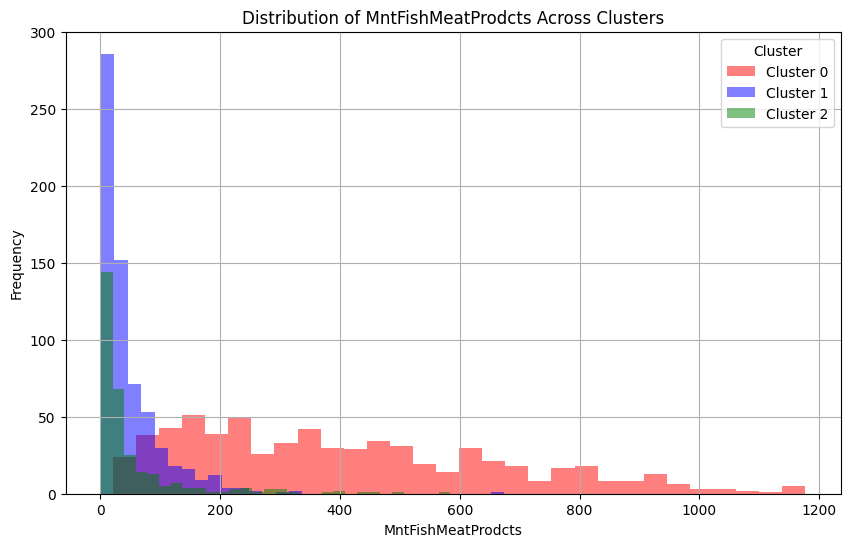

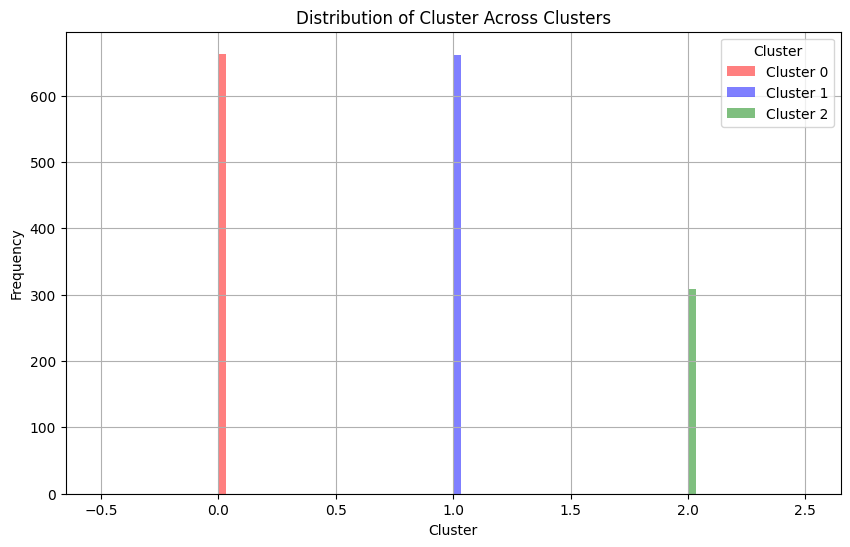

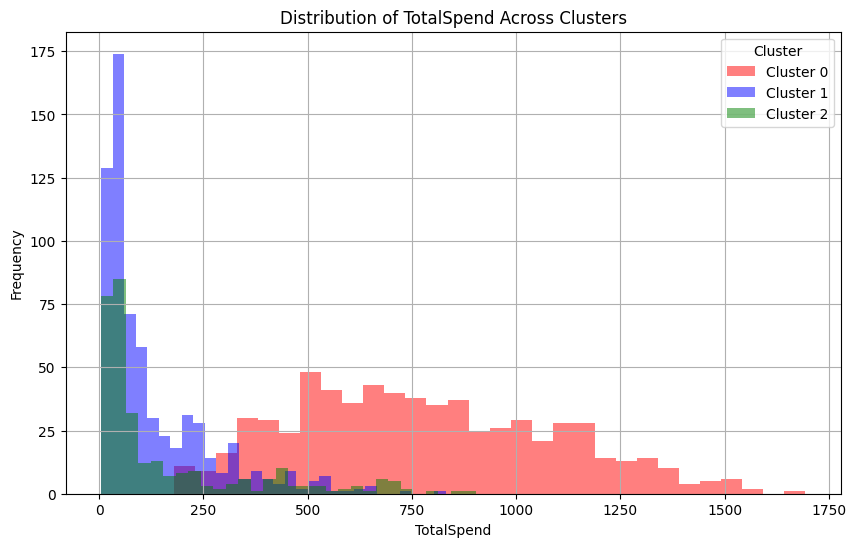

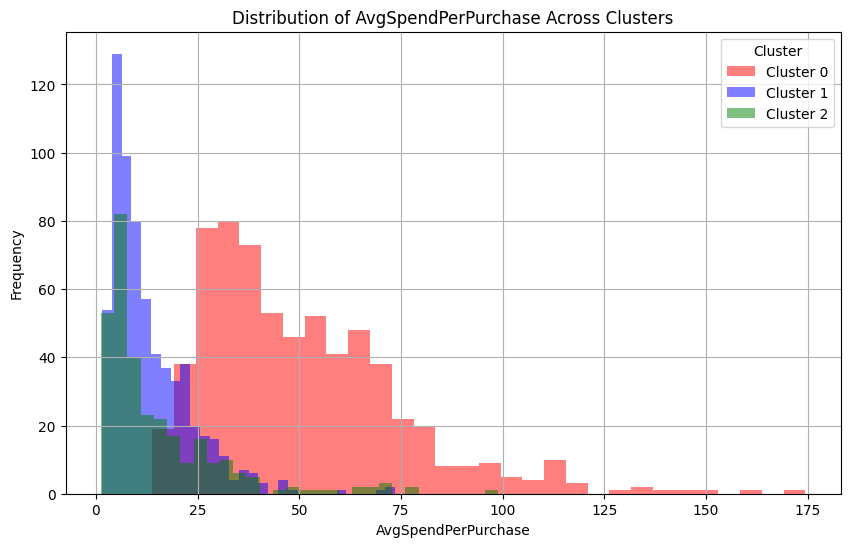

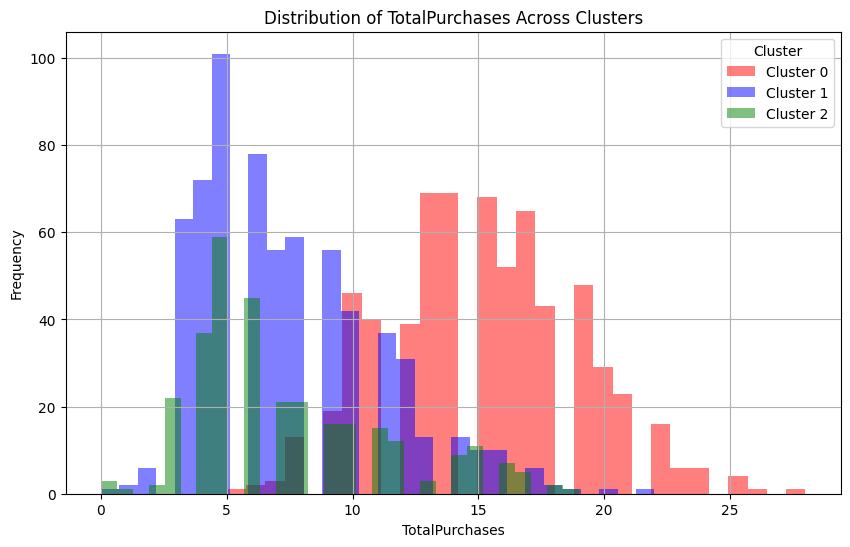

In [15]:
plot_histograms(unscaled_data_3)

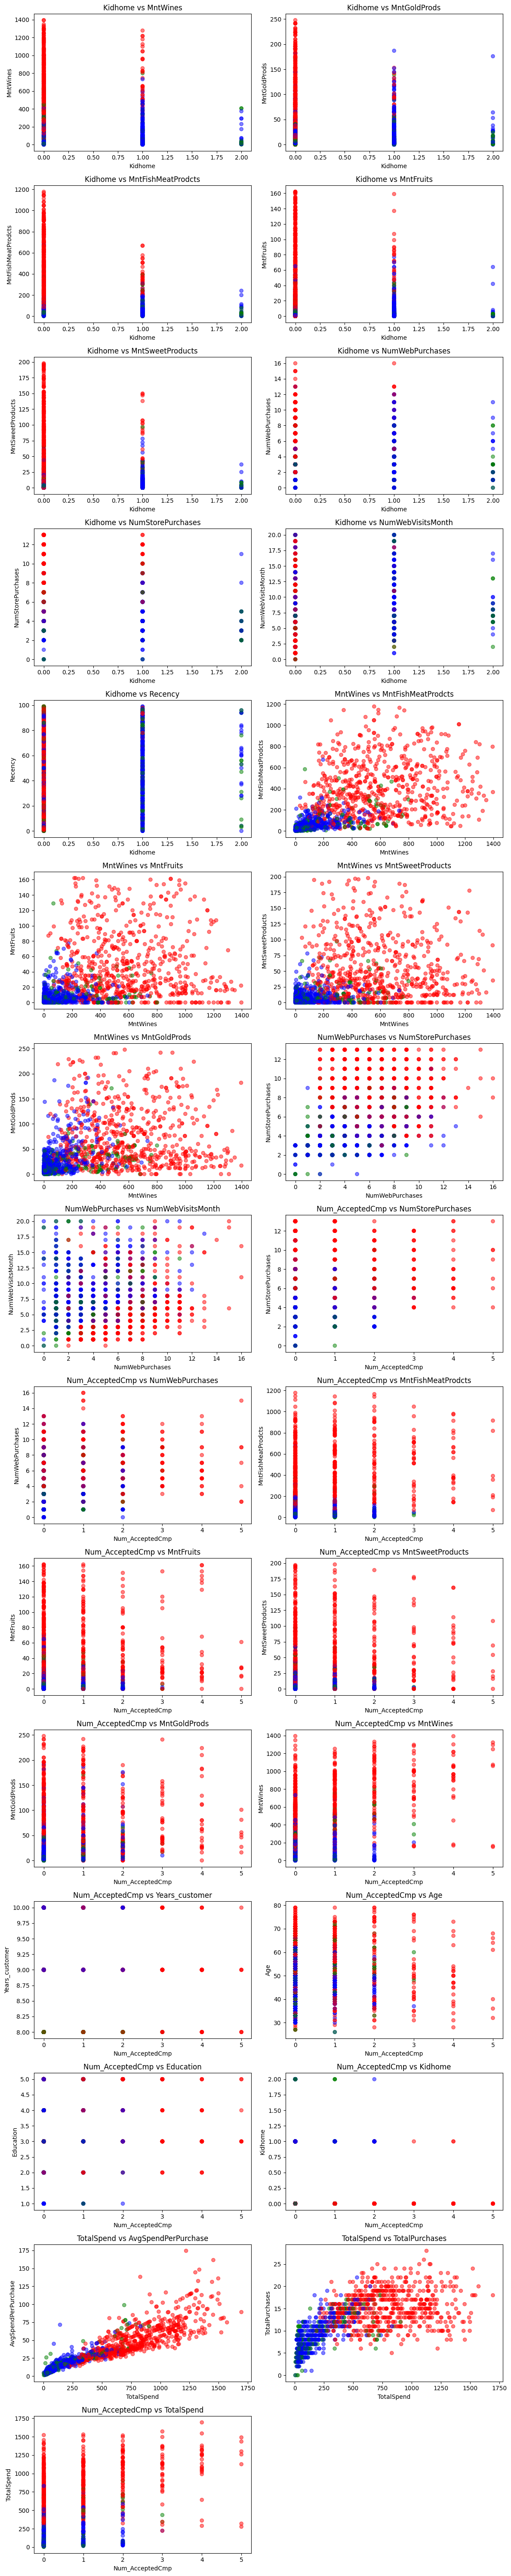

In [16]:
plot_comparisons(unscaled_data_3)

## PCA
To see whether visualization suggests a clustering in the data, we apply PCA with `p=2` and create a scatter plot.

In [17]:
from sklearn.decomposition import PCA

data, _ = prep.get_data(-1, remove_outliers=False, aggregate_features=False)

# Apply PCA
pca = PCA(n_components=2, random_state=0)
principal_components = pca.fit_transform(data_2)

print(f'Total explained vairance ratio for p=2: {np.sum(pca.explained_variance_ratio_)}')

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1', 'Principal Component 2'])

Total explained vairance ratio for p=2: 0.45132803094290175


PCA with `p=2` captures approximately 45% the data set. Even though it not entirely accurate, the PCA visualization strongly suggests a clustering of 3 clusters (possibly 4 or 5) clusters. We therefore proceed by assigning the clusters from KMeans to see if they align with the suggested clusters. 

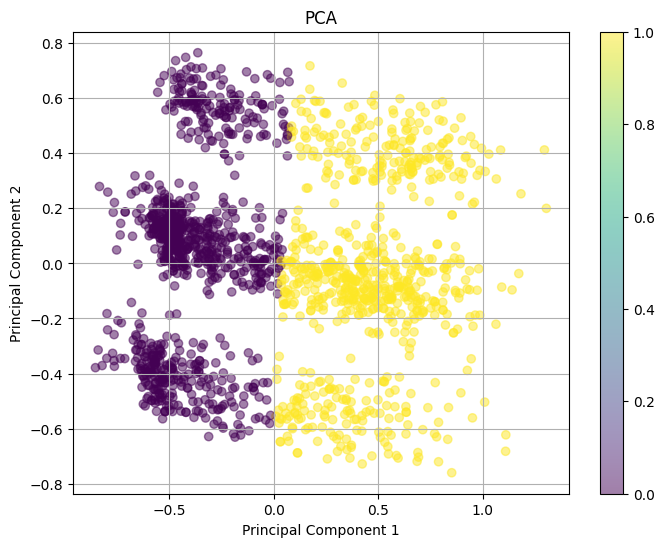

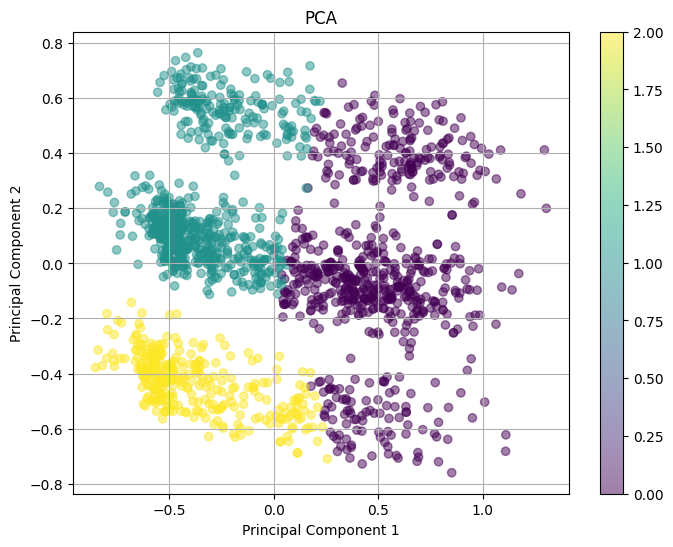

In [18]:
pca_df_2 = pca_df.copy()
pca_df_3 = pca_df.copy()

pca_df_2['Cluster'] = km_2.labels_
pca_df_3['Cluster'] = km_3.labels_

# Plot the PCA results
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df_2['Principal Component 1'], pca_df_2['Principal Component 2'], alpha=0.5, c=pca_df_2['Cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# Plot the PCA results
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df_3['Principal Component 1'], pca_df_3['Principal Component 2'], alpha=0.5, c=pca_df_3['Cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.title('PCA')
plt.grid(True)
plt.show()

The clusters suggested by PCA does not have a sphrerical shape. If this reflects the true nature of the data, it makes sense that the cluster clustering obtained by Kmeans does not align with the suggested clusters.

## t-SNE
To see whether visualization suggests a clustering in the data, we apply t-SNE with `n=2` and and `n=3`.

In [19]:
from sklearn.manifold import TSNE

data, _ = prep.get_data(-1, remove_outliers=True, aggregate_features=False)

Removing 9 wine outliers
Removing 34 fruit outliers
Removing 2 sweets outliers
Removing 3 gold outliers
Removing 0 web purchase outliers
Removing 5 fish_meat outliers


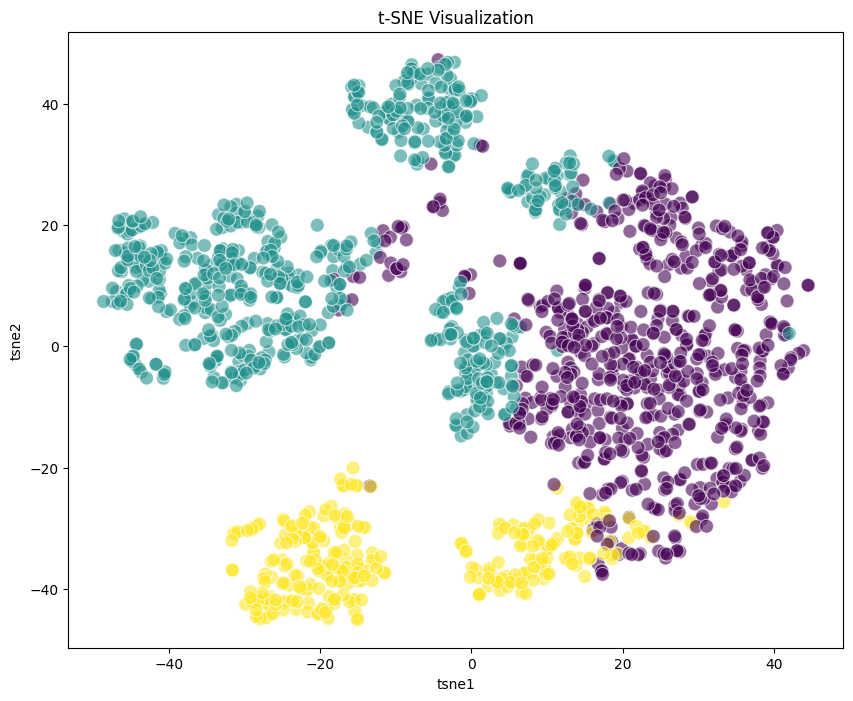

In [20]:
tsne2 = TSNE(n_components=2, random_state=0)
tsne_components = tsne2.fit_transform(data)
tsne2_df = pd.DataFrame(data=tsne_components, columns=['tsne1', 'tsne2'])
tsne2_df['Cluster'] = km_3.labels_

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', data=tsne2_df, s=100, alpha=0.6, c=tsne2_df['Cluster'])
plt.title('t-SNE Visualization')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

In [21]:
import plotly.express as px

tsne3 = TSNE(n_components=3, random_state=0)
tsne_components = tsne3.fit_transform(data)
tsne3_df = pd.DataFrame(data=tsne_components, columns=['tsne1', 'tsne2', 'tsne3'])
tsne3_df['Cluster'] = km_3.labels_



In [22]:
fig = px.scatter_3d(tsne3_df, x='tsne1', y='tsne2', z='tsne3', color='Cluster',)


fig.update_layout(title='3D t-SNE Plot ', 
                scene=dict(
                xaxis_title='tsne1',
                yaxis_title='tsne2',
                zaxis_title='tsne3',       
             ))

fig.show()

t-SNE with 2 and 3 dimensions suggests that there are 4-6 clusters in the data.

# Other things we tried

## DBSCAN

Visualizing the data with PCA suggested that the clusters in the data does not have spherical shapes. As Kmeans performs poorly on non-spherical clusters, we apply DBSCAN to the data. PCA with three dimensions has an explained variance ratio of ≈ 56,2%.

Out of curiosity, we try to get the DBSCAN model to find the 3 clusters suggested by PCA. We obtain this by setting `eps=0.18` and `min_samples=12`.

### Findings
We 

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dbscan_df_unscaled = pd.read_csv("customer_data_large.csv")
scaled = scaler.fit_transform(dbscan_df_unscaled)
dbscan_df = pd.DataFrame(scaled, index=dbscan_df_unscaled.index, columns=dbscan_df_unscaled.columns)


### Three clusters

In [24]:
from sklearn.cluster import DBSCAN


# Apply PCA
pca = PCA(n_components=3, random_state=0)
principal_components = pca.fit_transform(dbscan_df)
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])

print(f'Explained variance ratio: {np.sum(pca.explained_variance_ratio_)}')

# Apply DBSCAN
dbscan = DBSCAN(eps=0.18, min_samples=12) 
clusters = dbscan.fit_predict(pca_df)

sil = silhouette_score(pca_df, clusters)
print(f'Silhouette score for clustering: {silhouette_score(pca_df, clusters)}')


# Add clusters to the PCA df
pca_df['Cluster'] = clusters


Explained variance ratio: 0.5726701874124006
Silhouette score for clustering: 0.1875948043323938


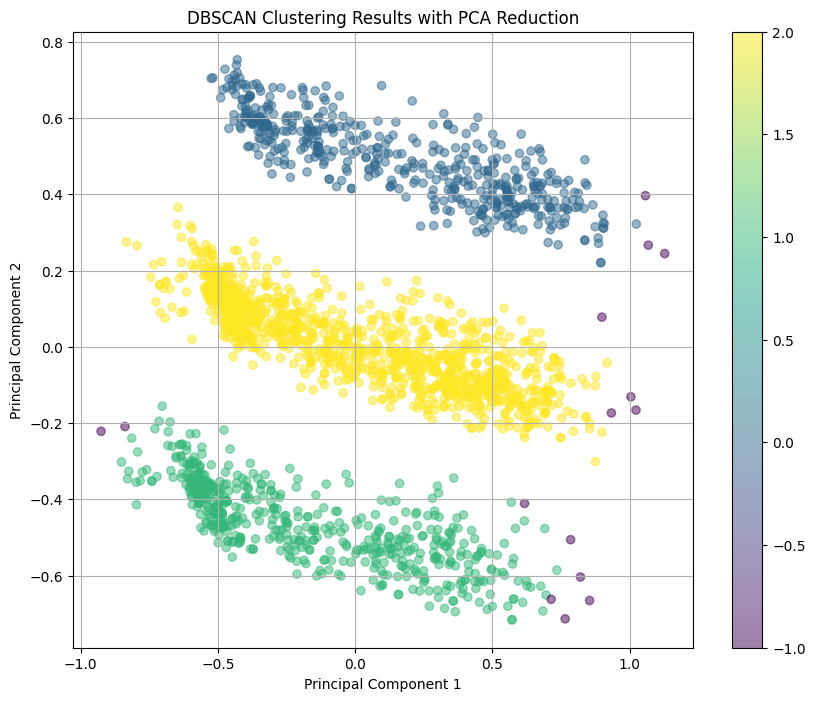

In [25]:
# Plot the clusterings
# 2 dimensions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering Results with PCA Reduction')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# 3 dimensions
fig = px.scatter_3d(pca_df, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                color='Cluster',
                color_continuous_scale=px.colors.qualitative.D3)  


fig.update_layout(title='3D PCA Plot of Clusters',
                scene=dict(
                    xaxis_title='Principal Component 1',
                    yaxis_title='Principal Component 2',
                    zaxis_title='Principal Component 3'
                ),
                coloraxis_colorbar=dict(
                    title='Cluster'
                ))

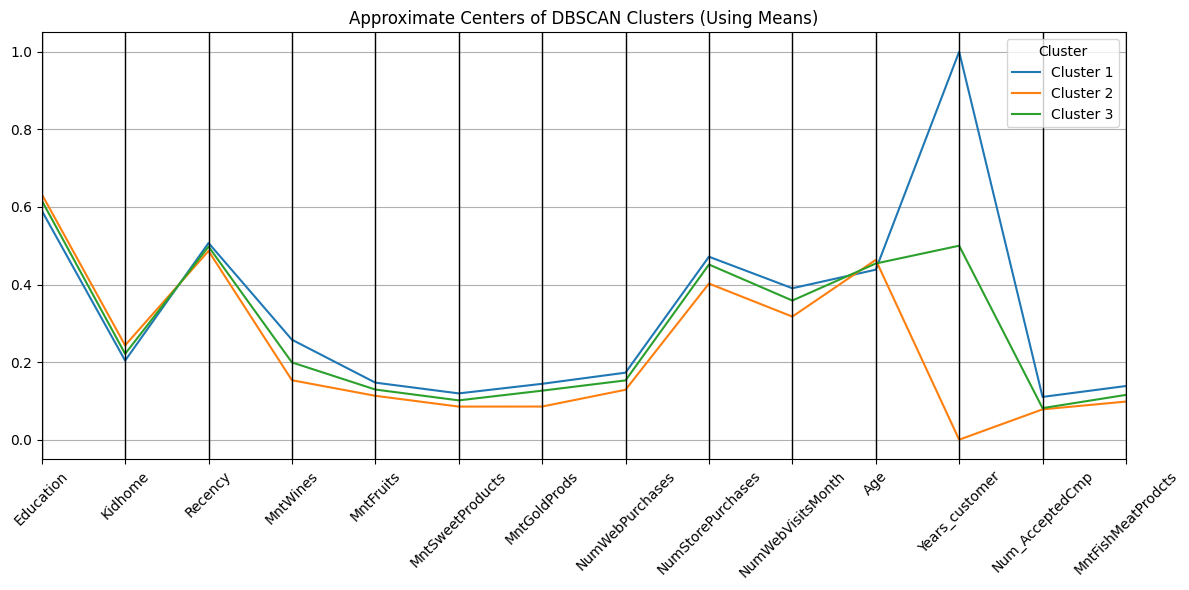

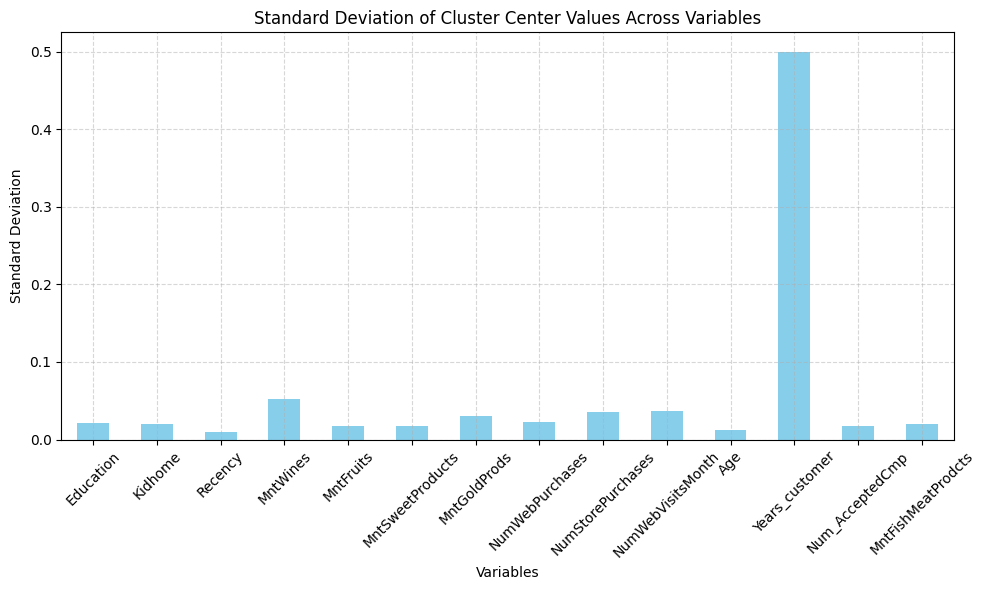

In [26]:
# Add clusters to original data
dbscan_df['Cluster'] = clusters
dbscan_df_unscaled['Cluster'] = clusters

# Remove noise points 
clustered_data = dbscan_df[dbscan_df['Cluster'] != -1]
dbscan_df_unscaled = dbscan_df_unscaled[dbscan_df_unscaled['Cluster'] != -1]

# Calculating the mean of points within each cluster
cluster_centers = clustered_data.groupby('Cluster').mean()

# Creating a DataFrame from these mean centers
centers_df = pd.DataFrame(cluster_centers, columns=dbscan_df.columns[:-1])  # exclude the Cluster column from means
centers_df.reset_index(inplace=True)
centers_df['Cluster'] = ['Cluster ' + str(x+1) for x in centers_df['Cluster']]  # Naming clusters for visualization

# Plotting the parallel coordinates
plt.figure(figsize=(12, 6))
ax = parallel_coordinates(centers_df, 'Cluster', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Approximate Centers of DBSCAN Clusters (Using Means)')
plt.xticks(rotation=45)  # Rotating x-axis labels to be vertical
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


# Compute the standard deviation for each variable across the cluster centers
std_dev = cluster_centers.std()
# Create a bar plot for the standard deviations
plt.figure(figsize=(10, 6))
std_dev.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Cluster Center Values Across Variables')
plt.xlabel('Variables')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', which='both', alpha=0.5)
plt.tight_layout()
plt.show()

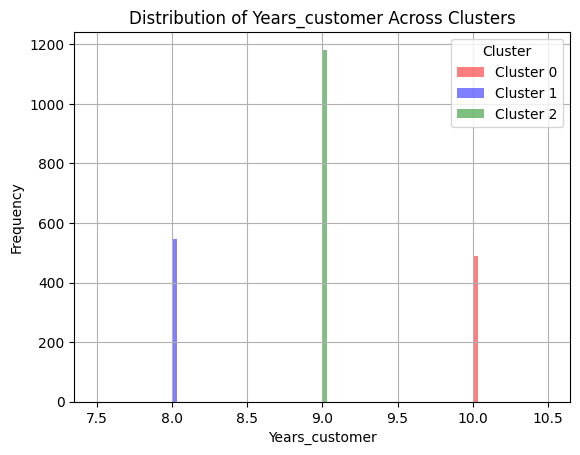

In [27]:
years_df = dbscan_df_unscaled[['Years_customer', 'Cluster']]

color_map = {0: 'red', 1: 'blue', 2: 'green'}

for cluster in sorted(years_df['Cluster'].unique()):
    subset = years_df[years_df['Cluster'] == cluster]
    plt.hist(subset['Years_customer'], bins=30, alpha=0.5, label=f'Cluster {cluster}', color=color_map[cluster])

plt.title(f'Distribution of Years_customer Across Clusters')
plt.xlabel('Years_customer')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(True)


From the above plots we see that the only differentiating feature is `Years_customer`. We therefore try to remove it, and see if we can get some more insightful clustering. 

In [28]:
scaler = MinMaxScaler()
dbscan_df = pd.read_csv("customer_data_large.csv")
dbscan_df = dbscan_df.drop('Years_customer', axis=1)
scaled = scaler.fit_transform(dbscan_df)
dbscan_df = pd.DataFrame(scaled, index=dbscan_df.index, columns=dbscan_df.columns)

# Apply PCA
pca = PCA(n_components=3, random_state=0)
principal_components = pca.fit_transform(dbscan_df)
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])

print(f'Explained variance ratio: {np.sum(pca.explained_variance_ratio_)}')

# Apply DBSCAN
dbscan = DBSCAN(eps=0.18, min_samples=12) 
clusters = dbscan.fit_predict(pca_df)

sil = silhouette_score(pca_df, clusters)
print(f'Silhouette score for clustering: {silhouette_score(pca_df, clusters)}')


# Add clusters to the PCA df
pca_df['Cluster'] = clusters

Explained variance ratio: 0.6021324942545689
Silhouette score for clustering: 0.2771399622193848


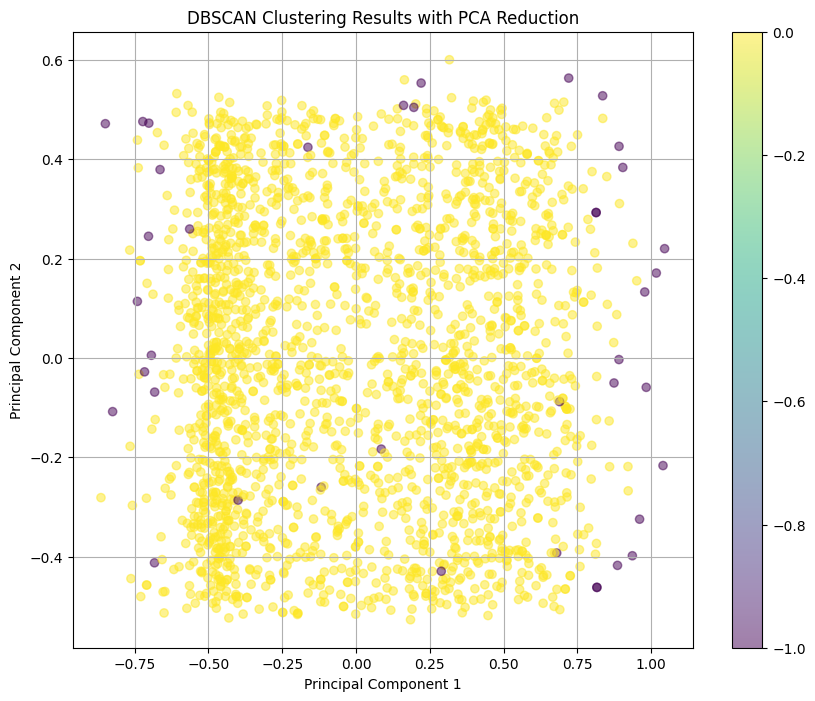

In [29]:
# Plot the clusterings
# 2 dimensions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering Results with PCA Reduction')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# 3 dimensions
fig = px.scatter_3d(pca_df, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                color='Cluster',
                color_continuous_scale=px.colors.qualitative.D3)  


fig.update_layout(title='3D PCA Plot of Clusters',
                scene=dict(
                    xaxis_title='Principal Component 1',
                    yaxis_title='Principal Component 2',
                    zaxis_title='Principal Component 3'
                ),
                coloraxis_colorbar=dict(
                    title='Cluster'
                ))